## First-order conservative regridding

In [97]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from os.path import expanduser
home = expanduser("~")

In [98]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

def plot_snapshot(var, cmap, variable_name, model):
    projection = ccrs.PlateCarree(central_longitude=180)
    lat = var.lat
    lon = var.lon

    f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(15, 5))

    var.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055}, cmap=cmap)
    ax.add_feature(cfeat.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.set_title(variable_name + ' snapshot, model:' + model)
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])
    ax.set_yticks([-20, 0, 20])
    plt.tight_layout()

### grid in

In [121]:
model='GFDL-CM3'
experiment='historical'
folder = '/Users/cbla0002/Documents/data/cmip5/ds'
fileName = model + '_pr4_orig_' + experiment + '.nc'
path = folder + '/' + fileName
ds_in = xr.open_dataset(path)
M_in = ds_in.pr.isel(time=0)
M_in

<xarray.DataArray 'pr' (time: 2, lat: 30, lon: 144)>
array([[[4.342670e-06, 3.116653e-06, ..., 6.127762e-06, 5.426103e-06],
        [4.517907e-06, 2.389717e-06, ..., 6.953840e-06, 5.739020e-06],
        ...,
        [7.862324e-10, 1.022034e-08, ..., 8.917287e-15, 2.917019e-10],
        [9.861120e-12, 2.545958e-10, ..., 3.778469e-09, 6.628639e-11]],

       [[7.237517e-06, 5.446147e-06, ..., 4.343579e-06, 5.069287e-06],
        [5.419511e-06, 4.758065e-06, ..., 3.225335e-06, 4.820581e-06],
        ...,
        [0.000000e+00, 0.000000e+00, ..., 1.067951e-14, 0.000000e+00],
        [7.994613e-14, 0.000000e+00, ..., 3.578735e-11, 1.420286e-11]]],
      dtype=float32)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 1970-01-02 12:00:00
  * lat      (lat) float64 -29.0 -27.0 -25.0 -23.0 -21.0 ... 23.0 25.0 27.0 29.0
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Attributes:
    long_name:         Precipitation
    units:             kg m-2 s-1
    cell_methods:      time: mean
    interp_method:     conserve_order1
    standard_name:     precipitation_flux
    original_units:    kg/m2/s
    original_name:     precip
    cell_measures:     area: areacella
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

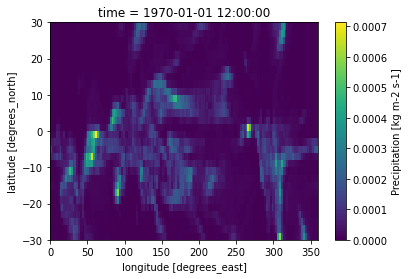

In [100]:
plot_snapshot(M_in, 'Blues', 'precipitation before regridding',model)
#M_in.plot()

### grid out / new matrix dimensions

In [101]:
M_out = xr.open_dataset(home + '/Documents/data/cmip5/FGOALS-g2/FGOALS-g2_ds_regid_historical.nc')

<xarray.DataArray 'precip' (lat: 22, lon: 128)>
array([[4.732160e-06, 3.620676e-06, 3.084236e-06, ..., 9.060055e-06,
        6.433906e-06, 5.688582e-06],
       [4.885616e-06, 2.785308e-06, 1.837272e-06, ..., 9.342233e-06,
        6.781115e-06, 6.070843e-06],
       [3.140866e-06, 1.373401e-06, 7.823898e-07, ..., 5.487783e-06,
        4.918055e-06, 4.693057e-06],
       ...,
       [2.209945e-09, 2.666124e-09, 5.369646e-10, ..., 0.000000e+00,
        3.218235e-14, 2.341952e-10],
       [1.880567e-09, 6.364814e-09, 2.622030e-09, ..., 5.314570e-16,
        3.989631e-15, 2.548717e-10],
       [2.169551e-09, 9.493050e-10, 5.345496e-10, ..., 5.402422e-08,
        6.124450e-08, 4.395237e-08]], dtype=float32)
Coordinates:
    time     object 1970-01-01 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2

### weights

In [102]:
dlat = M_in.lat.data[1]-M_in.lat.data[0]
dlon = M_in.lon.data[1]-M_in.lon.data[0]
latBnds = (M_in.lat.data-(dlat/2), M_in.lat.data+(dlat/2))
lonBnds = (M_in.lon.data-(dlon/2), M_in.lon.data+(dlon/2))
lat = np.mean(latBnds, axis=0)
lon = np.mean(lonBnds, axis=0)
# area of gridboxes as fraction of earth surface area
area_wlat = np.cos(np.deg2rad(lat))*dlat*np.pi/(4*180^2)

In [103]:
dlat_n = M_out.lat.data[1]-M_out.lat.data[0]
dlon_n = M_out.lon.data[1]-M_out.lon.data[0]
latBnds_n = (M_out.lat.data-(dlat_n/2), M_out.lat.data+(dlat_n/2))
lonBnds_n = (M_out.lon.data-(dlon_n/2), M_out.lon.data+(dlon_n/2))
lat_n = np.mean(latBnds_n, axis=0)
lon_n = np.mean(lonBnds_n, axis=0)

In [104]:
Wlat = np.zeros([len(lat_n), len(lat)])
for i in np.arange(0,len(lat_n)):
    latBoxMin_n = latBnds_n[0][i]
    latBoxMax_n = latBnds_n[1][i]

    # gridboxes that are atleast partially overlapping with iteration gridbox
    J = (latBnds[0]<=latBoxMax_n)*(latBnds[1]>= latBoxMin_n)*area_wlat

    # including fractional area component contribution
    I = J*(latBnds[1]-latBoxMin_n)/dlat
    K = J*(latBoxMax_n-latBnds[0])/dlat
    II = np.min([I,J,K], axis=0)

    # weights from individual gridboxes contributing to the new gridbox as fraction of the total combined area contribution
    Wlat[i,:] = II/np.sum(II)


In [105]:
Wlon = np.zeros([len(lon_n), len(lon)])
for i in np.arange(0,len(lon_n)):
    lonBoxMin_n = lonBnds_n[0][i]
    lonBoxMax_n = lonBnds_n[1][i]

    # gridboxes that are atleast partially overlapping with iteration gridbox
    J = (lonBnds[0]<=lonBoxMax_n)*(lonBnds[1]>= lonBoxMin_n)*1

    # Including fractional area component contribution
    I = J*(lonBnds[1]-lonBoxMin_n)/dlon
    K = J*(lonBoxMax_n-lonBnds[0])/dlon
    L = J*(lonBoxMax_n-lonBnds[0]+360)/dlon
    II = np.min([I,J,K,L], axis=0)

    # weights from individual gridboxes contributing to the new gridbox as fraction of the total combined area contribution
    Wlon[i,:] = II/np.sum(II)

### interpolation

In [106]:
M_Wlat = np.zeros([len(lat_n), len(lon)])
for i in range(0, np.shape(Wlat)[0]):
    
    M_Wlat[i,:] = np.nansum(M_in * np.vstack(Wlat[i,:]),axis=0)/np.sum(~np.isnan(M_in)*1*np.vstack(Wlat[i,:]),axis=0)


In [107]:
M_n = np.zeros([len(lat_n), len(lon_n)])
for i in range(0, np.shape(Wlon)[0]):
    
    M_n[:,i] = np.nansum(M_Wlat * Wlon[i,:],axis=1)/np.sum(~np.isnan(M_Wlat)*1*Wlon[i,:], axis=1)



In [108]:
M_n = xr.DataArray(
    data = M_n,
    dims = {'lat', 'lon'},
    coords = {'lat': M_out.lat.data, 'lon': M_out.lon.data},
    attrs = M_in.attrs
)


In [120]:
# plot_snapshot(M_n, 'Blues', 'precipitation after regridding',model)
# M_n.plot()

### function

In [ ]:
M_in = ds_in.pr.isel(time=slice(0,2))
M_out = xr.open_dataset(home + '/Documents/data/cmip5/FGOALS-g2/FGOALS-g2_ds_regid_historical.nc')

In [127]:
def regrid_conserv_np(M_in, M_out):

    # dimensions
    dlat = M_in.lat.data[1]-M_in.lat.data[0]
    dlon = M_in.lon.data[1]-M_in.lon.data[0]
    latBnds = (M_in.lat.data-(dlat/2), M_in.lat.data+(dlat/2))
    lonBnds = (M_in.lon.data-(dlon/2), M_in.lon.data+(dlon/2))
    lat = np.mean(latBnds, axis=0)
    lon = np.mean(lonBnds, axis=0)
    # area of gridboxes as fraction of earth surface area
    area_wlat = np.cos(np.deg2rad(lat))*dlat*np.pi/(4*180^2)

    dlat_n = M_out.lat.data[1]-M_out.lat.data[0]
    dlon_n = M_out.lon.data[1]-M_out.lon.data[0]
    latBnds_n = (M_out.lat.data-(dlat_n/2), M_out.lat.data+(dlat_n/2))
    lonBnds_n = (M_out.lon.data-(dlon_n/2), M_out.lon.data+(dlon_n/2))
    lat_n = np.mean(latBnds_n, axis=0)
    lon_n = np.mean(lonBnds_n, axis=0)



    # weights
    Wlat = np.zeros([len(lat_n), len(lat)])
    for i in np.arange(0,len(lat_n)):
        latBoxMin_n = latBnds_n[0][i]
        latBoxMax_n = latBnds_n[1][i]

        # gridboxes that are atleast partially overlapping with iteration gridbox
        J = (latBnds[0]<=latBoxMax_n)*(latBnds[1]>= latBoxMin_n)*area_wlat

        # including fractional area component contribution
        I = J*(latBnds[1]-latBoxMin_n)/dlat
        K = J*(latBoxMax_n-latBnds[0])/dlat
        II = np.min([I,J,K], axis=0)

        # weights from individual gridboxes contributing to the new gridbox as fraction of the total combined area contribution
        Wlat[i,:] = II/np.sum(II)

    Wlon = np.zeros([len(lon_n), len(lon)])
    for i in np.arange(0,len(lon_n)):
        lonBoxMin_n = lonBnds_n[0][i]
        lonBoxMax_n = lonBnds_n[1][i]

        # gridboxes that are atleast partially overlapping with iteration gridbox
        J = (lonBnds[0]<=lonBoxMax_n)*(lonBnds[1]>= lonBoxMin_n)*1

        # Including fractional area component contribution
        I = J*(lonBnds[1]-lonBoxMin_n)/dlon
        K = J*(lonBoxMax_n-lonBnds[0])/dlon
        L = J*(lonBoxMax_n-lonBnds[0]+360)/dlon
        II = np.min([I,J,K,L], axis=0)

        # weights from individual gridboxes contributing to the new gridbox as fraction of the total combined area contribution
        Wlon[i,:] = II/np.sum(II)



    # interpolation
    M_n = np.zeros([len(M_in.time.data), len(lat_n), len(lon_n)])
    for day in np.arange(0,len(M_in.time.data)):
        M_Wlat = np.zeros([len(lat_n), len(lon)])

        for i in range(0, np.shape(Wlat)[0]):
            M_Wlat[i,:] = np.nansum(M_in.isel(time=day) * np.vstack(Wlat[i,:]),axis=0)/np.sum(~np.isnan(M_in.isel(time=day))*1*np.vstack(Wlat[i,:]),axis=0)
            
        for i in range(0, np.shape(Wlon)[0]):
            M_n[day,:,i] = np.nansum(M_Wlat * Wlon[i,:],axis=1)/np.sum(~np.isnan(M_Wlat)*1*Wlon[i,:], axis=1)

    return M_n

In [128]:
M_n = regrid_conserv_np(M_in)

In [129]:
np.shape(M_n)

(2, 22, 128)

In [136]:
M_n = xr.DataArray(
    data = M_n,
    dims = ['time', 'lat', 'lon'],
    coords = {'time': M_in.time.data, 'lat': M_out.lat.data, 'lon': M_out.lon.data},
    attrs = M_in.attrs
)

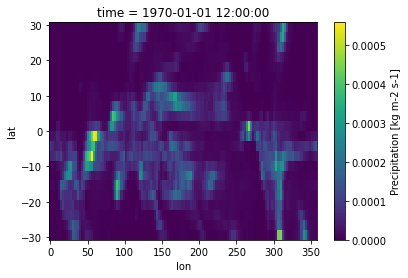

In [138]:
plot_snapshot(M_n.isel(time=0), 'Blues', 'precipitation after regridding',model)
#M_n.isel(time=0).plot()

## grid with vertical coordinate (plev)

In [ ]:
# M_n = xr.DataArray(
#     data = M_n,
#     dims = {'time', 'plev', 'lat', 'lon'},
#     coords = {'time': M_in.time.data, 'plev':M_in.plev.data, 'lat': M_in.lat.data, 'lon': M_in.lon.data},
#     attrs = M_in.attrs
# )

In [145]:
# a = np.vstack(np.array([1,2,3]))
# np.shape(a)
# c = np.expand_dims(a,axis=2)
# np.shape(c)

(3, 1, 1)